# Project: **Richardson Extrapolation** in **numdifftools**

## Group members
* Darrien Lee
* Peter Minwegen
* Nicholas Palmer
* Benji Goldstein

This notebook is a blank slate for you to write in.  Feel free to include figures (don't forget to add/commit them to your repository) and examples.  You can change the kernel (from `Python 3`; see upper right) if the open source project you're writing about does not use Python.  You can write from the prompts below or delete all the cells and start fresh.  Note that Git will always contain your history.

You can run shell commands:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd

Note that some of the content for this section was used from Nicholas Palmer's individual project on Richardson Extrapolation, and that all of the content of this notebook is solely the work of the group members listed above.

## Introduction

Describe the objective of your study, citing prior work as appropriate (papers, websites, etc.).  There is no requirement on citation style, but please try to be consistent.

The objective of the study for this project is to "break" the numdiftools software by violating some assumptions on the inputs for the software, as well as attempting to violate the assumptions of the Richardson Extrapolation method. In this section we will describe the Richardson Extrapolation method and how it is useful for numerical differentiation. Then in the following sections we will describe the methodology for performing these tests and studies, how that affects usability and usefulness of numdiftools for the average user, any conclusions as a result of the study, and finally any open questions at the end of the study.  

Richardson extrapolation can be used to obtain high numerical accuracy by taking the linear combination of successive approximations of numerical derivatives. This method is described below: 

We can calculate the derivative of a function $f(x)$ by using the centered limit definition of the derivative:

$$f'(x) = \lim_{h \rightarrow 0} \frac{f(x + h) - f(x - h)}{2h}$$

Where $h$ is the step size. This, of course, assumes that we can make $h$ arbitrarily small. However, numerically this is impossible, as computers have a limit on the range of numbers that they can represent. Therefore, using this method, we can only represent values of $h$ that are as small as $\epsilon_{machine}$. Therefore, since we must use representable step sizes for $h$, we can rework the above definition to include an error term: 

$$f'(x) = \frac{f(x + h) - f(x - h)}{2h} + O(h^2)$$

From this we can see that the error term is on the order of $h^2$. From this, it must seem that when we reduce $h$ by half, we should reduce the error by a factor of 4. Let us see how this works in practice below. 

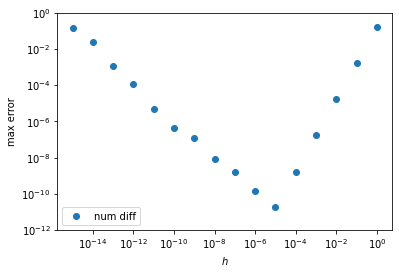

In [4]:
#Note that this code was taken from the 4/7 in class activity for illustrative purposes
#Slight modifications were made
def compute_errors(diff, f, fp, x=np.linspace(-4, 4)):
    hs = np.geomspace(1e-15, 1, 16)
    errors = [np.linalg.norm(diff(f, x, h) - fp(x), np.inf) for h in hs]
    return hs, errors


def diff2(f, x, h):
    return (f(x + h) - f(x - h)) / (2*h)

hs, errors = compute_errors(diff2, np.sin, np.cos)

plt.loglog(hs, errors, 'o', label='num diff')
plt.xlabel('$h$')
plt.ylabel('max error')
plt.ylim(1e-12, 1)
plt.legend();

The main reason that we see this type of behavior is due to subtractive cancellation. Subtractive cancellation is the error that is introduced by subtracting two values with finite accuracy that are very close to each other. Recall the original function for computing the derivative of a function:

$$f'(x) = \frac{f(x + h) - f(x - h)}{2h} + O(h^2)$$

As $h$ gets smaller and smaller, the values of $f(x + h)$ and $f(x - h)$ successively get closer together. Because the calculation for $f(x)$ has finite accuracy, we begin to require greater and greater accuracy in our calculation of $f(x)$ to avoid this subtractive cancellation error. We can see this in action below. 

Suppose we want to calculate $f(x + h) - f(x)$ with 10 digits of accuracy. If $h = 0.00001$, $x = 1$, and $f(x) = sin(x)$, we need 15 digits of accuracy when calculating $sin(1.01)$, since the first 5 digits of the calculation cancel to zero. 

$$\frac{sin(1.00001) - sin(1)}{0.1}$$

Doing the calculations we get the following: 

$$
\begin{align*}
&0.841476387788881\\   
-\phantom{y=}&&\\    
&0.841470984807896\\\hline   
&0.000005402980985    
\end{align*}
$$

So, from this we can see that when $h$ get sufficiently small, we begin to get subtractive cancellation due to the finite accuracy of our calculation of $f(x)$.

<hr>

We can again rework the above definition to see that the error is proportional to $h^2$.

$$f'(x) \approx \frac{f(x + h) - f(x - h)}{2h} + Ch^2$$

Now we can see that the error in the above term is proportional to some constant C. For the sake of syntactical simplicity, let us define the centered differentiation of a function $f$ at a point $x$ with step size $h$ as follows: 

$$D(f, x, h) = \frac{f(x + h) - f(x - h)}{2h}$$

Where the error term can be expressed as $Ch^2$. We now know that the true value for a derivative $T_v$ can be approximated as follows: 

$$T_v = D(f, x, h) + Ch^2$$

When we halve the step size to $h/2$, we obtain the following: 

$$T_v = D(f, x, \frac{h}{2}) + C\frac{h^2}{4}$$

Now, we can solve the above system of equationms for $T_v$ by subtracting out the term $C$:

$$
\begin{align*}
&T_v = D(f, x, h) + Ch^2\\   
-\phantom{y=}&&\\    
&4T_v = 4D(f, x, \frac{h}{2}) + Ch^2\\\hline   
&-3T_v = D(f, x, h) - 4D(f, x, \frac{h}{2})
\end{align*}
$$

Simplifying: 

$$T_v = \frac{4D(f, x, \frac{h}{2}) - D(f, x, h)}{3}$$

Now, we have again solved for the value $T_v$, however, we now avoid the subtractive cancellation error, as $4D(f, x, \frac{h}{2})$ and $F(f, x, h)$ are not so close to each other any more.

In fact, we see that the formula for each entry is as follows: 

$$R_{i, n} = \frac{2^n R_{i, n-1} - R_{i-1, n-1}}{2^n - 1}$$

If we think of these entries as being a matrix, we notice that each entry is simply a linear combination of two other entries. Using this we can write a function which allows us to calculate the first column of entries, and then successively calculate the next columns in the matrix.

The only limit on how many times this can be repeated is how small $h$ can be represented on the machine. Below we calculate how many times this could be repeated (the results are as calculated on my machine). 

## Methods



In [1]:
from math import *
def zeros(n,m): # zeros matrix 
    Z=[]
    for i in range(n):
        Z.append([0]*m)
    return Z

def D(Func,a,h):    
    return (Func(a+h)-Func(a-h))/(2*h)
def Dwithsmallh(Func,a,h):   
    h = h * 0.000000000000000001
    return (Func(a+h)-Func(a-h))/(2*h)

def Richardson_dif(func,a):
    '''Richardson extrapolation method for numerical calculation of first derivative '''
    k=9 # change the order of approximation
    L=zeros(k,k)
    L2=zeros(k,k)
    for I in range(k):
        L[I][0]=D(func,a,1/(2**(I+1)))
        #L2[I][0]=Dwithsmallh(func,a,1/(2**(I+1)))
    for j in range(1,k):
        for i in range(k-j):
            L[i][j]=((4**(j))*L[i+1][j-1]-L[i][j-1])/(4**(j)-1)
    return L[0][k-1]
def Richardson_difh(func,a):
    '''Richardson extrapolation method for numerical calculation of first derivative '''
    k=9 #  change the order of approximation
    L=zeros(k,k)
    L2=zeros(k,k)
    for I in range(k):
        L[I][0]=Dwithsmallh(func,a,1/(2**(I+1)))
    for j in range(1,k):
        for i in range(k-j):
            L[i][j]=((4**(j))*L[i+1][j-1]-L[i][j-1])/(4**(j)-1)
    return L[0][k-1]
print('Numerical differentiation of Func=-0.1*x**4-0.15*x**3-0.5*x**2-0.25*x+1.2 at x=0.5:', '%04.20f'%Richardson_dif(lambda x: -0.1*x**4-0.15*x**3-0.5*x**2-0.25*x+1.2 ,0.5))
print('Acceptable H value diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = %04.20f'%Richardson_dif(lambda x: 2**cos(pi+sin(x)),pi/3))
print('Richardson dif with acceptable H value diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = %04.20f'%Richardson_dif(lambda x: cos(x),pi/3))
print('Richardson dif with abusurdly small H diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = %04.20f'%Richardson_difh(lambda x: cos(x),pi/3))


Numerical differentiation of Func=-0.1*x**4-0.15*x**3-0.5*x**2-0.25*x+1.2 at x=0.5: -0.91250000000000530687
Acceptable H value diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = 0.16849558398154249050
Richardson dif with acceptable H value diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = -0.86602540378445724834
Richardson dif with abusurdly small H diff(2**cos(pi+sin(x)) at x=pi/2 is equal to = 0.00000000000000000000


### Specifying Too Many Richardson Extrapolations

Here we will attempt to break the numdifftools package by specifying the the number of richardson terms to compute when taking the derivative. It is useful to know the bounds of how many richardson extrapolation terms can be computed, as the more terms you can compute, the higher your accuracy. The limit on the number of terms that can be comptued is how small machine epsilon is. Below we can see some code to calculate two 8th order derivatives of the function $x^{10}$. The blue line is the 8th order derivative with only 2 richardson extrapolations calculated. The red line is the same 8th order derivative, but calculated with 11 richardson extrapolation terms. The plot clearly shows that as the number of richardson extrapolations gets higher that noise dominates the problem. This is likely due to inaccuracies when calculating $x^{10}$. Note that when representing floating point numbers with a large number of decimals, the representation will not be accurate. Therefore, this inaccuracy is amplified by the process of Richardson extrapolation, as calculating more and more terms will successively make h smaller and smaller. Doing so introduces more error into the original calculation of $f(x)$, which becomes amplified as linear combinations are taken in order to perform Richardson extrapolation. 

Note that in the plot below, the derivative seems to behave close to zero, as linear combinations of terms close to zero will tend to be zero. However, once the terms become larger than 1, amplification of the error becomes extremely large due to taking linear combinations of inaccurate numbers.

For the end user of numdifftools this becomes important, as numdifftools may not be a good choice when extremely accurate results are needed or when a large number of richardson extrapolations are needed. 

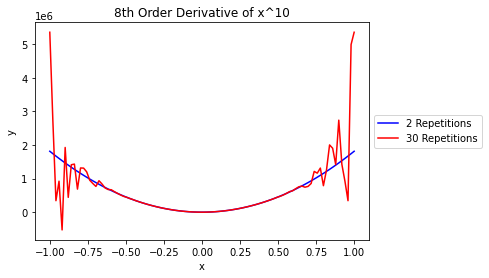

In [43]:
x = np.linspace(-1, 1, 100)

#Define some function to take the derivative of
def f(x):
    return x**10

# Perform the derivative with 2 richardson extrapolation terms
df = nd.Derivative(f, n=8)
df.richardson_terms = 2 # Specify the default number of richardson extrapolation terms
y = df(x)
h = plt.plot(x, y, color='blue', label='2 Repetitions')

# Perform the derivative with 11 richardson extrapolations
# This will force too many extrapolations to occur, meaning that h will be less than machine epsilon
df = nd.Derivative(f, n=8)
df.richardson_terms = 11 # Specify 11 richardson extrapolation terms
y = df(x)
h = plt.plot(x, y, color='red', label="30 Repetitions")
    
plt.title("8th Order Derivative of x^10")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0,0.5,'y')

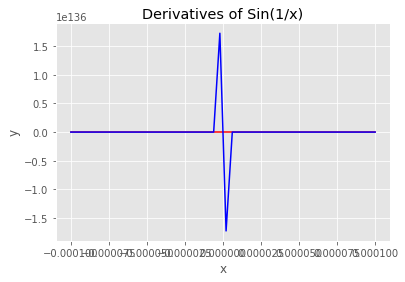

In [24]:
#12th order derivative of sin(1/x)
def highdev(x):
    return (
        (np.sin(1/x)/x**24)-(132*np.cos(1/x)/x**23)-(7260*np.sin(1/x)/x**22)+(217800*np.cos(1/x)/x**21)+(3920400*np.sin(1/x)/x**20)
        -(43908480*np.cos(1/x)/x**19)-(307359360*np.sin(1/x)/x**18)+(1317254400*np.cos(1/x)/x**17)+(3293136000*np.sin(1/x)/x**16)
        -(439084800*np.cos(1/x)/x**15)-(2634508800*np.sin(1/x)/x**14)+(479001600*np.cos(1/x)/x**13)
        )
highdev(1)
def f(x):
    return np.sin(1/x)
df = nd.Derivative(f,12)
error=[0,0,0,0,0]
for x in range(5):
    error[x]=df(x+1)-highdev(x+1)
error
'''
xi = np.linspace(-0.01, 0.01, 100)

y = df(xi)
h = plt.plot(xi, y, color='red')
y = highdev(xi)
h = plt.plot(xi, y, color='blue')
plt.title("Derivatives of Sin(1/x)")
plt.xlabel("x")
plt.ylabel("y")
'''

xi = np.linspace(-0.0001, 0.0001, 50)

y = df(xi)
h = plt.plot(xi, y, color='red')
y = highdev(xi)
h = plt.plot(xi, y, color='blue')
plt.title("Derivatives of Sin(1/x)")
plt.xlabel("x")
plt.ylabel("y")

Here we can see that the actual derivative has some features nearby to zero. However the derivative apporiximation made by numdifftools does not have any non-zero features nearby to zero. This example and the one below show that the increasing variance as within the area doesn't allow the estimator to close in on the solution. This is especially bad in the case of sin(1/x) because the varience heads towards infinity.

In the comparison between the actual 12th derivative of sin(1/x) and the richardson approximation, we can see that except for the closest point to 0 they roughly agree, this is true even as you change the scale of the graph. Because the richardson approximation around zero assumes it is a flat line, which is not the case.

In the second test we can see that 1/x for every triginometric function fails for the same reason. Although its not obvious if cos and sin fail in the same way. This is a special case for this varience, as sin(x) and cos(x) and others as seen can do very high level derivatives without falling into the trap of assuming they are roughly flat when they are not. This shows that this method is very close to newtonian approximation methods for derivatives, and therefor shares many of the same limiations.

Text(0,0.5,'y')

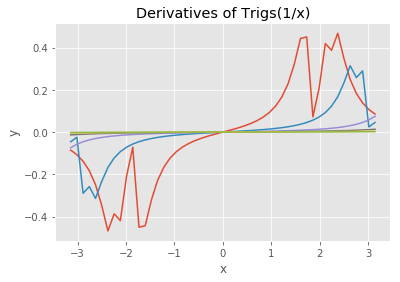

In [45]:
def oversin(x):
    return np.sin(1/x)
    #return np.sin(x)

def overcos(x):
    return np.cos(1/x)
    #return np.cos(x)

def div5sin(x):
    return ((20*x*(12*x**2-1)*np.sin(1/x))+(-120*x**4+120*x**2-1)*np.cos(1/x))/x**10


xi = np.linspace(-np.pi, np.pi, 50)
'''
df = nd.Derivative(oversin,5)
dg = nd.Derivative(overcos,5)
dh = nd.Derivative(overcos,6)
y = df(xi)
h = plt.plot(xi, y, color='red')
y = dg(xi)
h = plt.plot(xi, y, color='blue')

y = dh(xi)
h = plt.plot(xi, y, color='green')
'''
for x in range(6):
    dg = nd.Derivative(overcos,2+x)
    y=dg(xi)
    h = plt.plot(xi,y)
plt.title("Derivatives of Trigs(1/x)")
plt.xlabel("x")
plt.ylabel("y")

### Breaking Richardson Extrapolation using Decimals Powers

In this method, we will attempt to break the numdifftools package by using decimal powers in the derivative function. As decimal powers are well-known and explored in the derivative and integration fields using the power rule, which contains the domain of fractional powers, we attempted to apply this to nummdifftool's packages.

The derivatives of any power in the decimals (aka 0.1, 1/10, np.sqrt) returns the same exact 9 runtime errors and warnings (for a total of 21 errors/warnings) from the numdifftools package with the code below. The domain of the numdifftools seems to be that of whole numbers and does not work with fractions or decimals in the power.

Even for the first derivative of any of these functions (which are well known and easily calculated by hand, the numdifftools package breaks (albiet not with legit values with errors based off of h like the previous methods).

/opt/conda/lib/python3.7/site-packages/numdifftools/core.py:325: RuntimeWarning: invalid value encountered in sqrt
  return fun(x, *args, **kwds)
/opt/conda/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/opt/conda/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/opt/conda/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/opt/conda/lib/python3.7/site-packages/numdifftools/l

Text(0, 0.5, 'y')

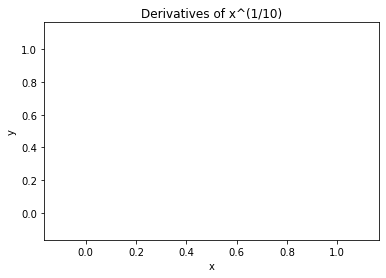

In [3]:
# Runtime warning with sqrt
import math

x = np.linspace(-1, 1, 100)

def f1(x):
    return x**(0.1)

def f2(x):
    return x**(1/10)

#math.sqrt
df = nd.Derivative(np.sqrt, n=1) # first derivative breaks
df.richardson_terms = 1
y = df(x)
h = plt.plot(x, y, color='black')
plt.title("Derivatives of x^(1/10)")
plt.xlabel("x")
plt.ylabel("y")

#using def f(x) = x ** (0.1)
df = nd.Derivative(f1, n=1) # first derivative breaks
df.richardson_terms = 1
y = df(x)
h = plt.plot(x, y, color='green')
plt.title("Derivatives of x^(1/10)")
plt.xlabel("x")
plt.ylabel("y")

#using def f(x) = x ** (1/10)
df = nd.Derivative(f2, n=1) # first derivative breaks
df.richardson_terms = 1
y = df(x)
h = plt.plot(x, y, color='blue')
plt.title("Derivatives of x^(1/10)")
plt.xlabel("x")
plt.ylabel("y")

## Conclusions and open questions

